Walk-Forward Windows:   0%|          | 0/2 [00:00<?, ?it/s]


🔍 W1 – Training: 2021-01-01 → 2021-09-30 | Test: 2021-10-10 → 2021-12-31

🔍 Top SHAP features for W1:
       feature  mean_abs_shap
   macd_signal       0.002442
          open       0.002237
           cmf       0.001505
volatility_atr       0.000908
         close       0.000806
           obv       0.000345
           adx       0.000152
          high       0.000000
      ema_long       0.000000
     ema_short       0.000000
✂️ W1: Dropping 18 features under SHAP threshold (0.0003)
⚠️ Only 6 features passed threshold, using top-8 features instead
✅ Using 8 features that passed SHAP threshold
✅ W1: Final features used for retrain: ['open', 'high', 'close', 'volatility_atr', 'obv', 'macd_signal', 'adx', 'cmf']


Walk-Forward Windows:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s]

📊 W1: R²=-0.9153 | MAE=0.0834 | RMSE=0.0974 | Hit=0.4096 | IC=-0.2210

🔍 W2 – Training: 2021-01-01 → 2021-11-30 | Test: 2021-12-10 → 2022-02-28

🔍 Top SHAP features for W2:
    feature  mean_abs_shap
        cmf       0.004552
        rsi       0.004169
        obv       0.004072
     hma_14       0.003971
macd_signal       0.003827
   ema_long       0.003287
        adx       0.003253
       open       0.002498
       vwap       0.002267
      close       0.002033
✂️ W2: Dropping 4 features under SHAP threshold (0.0003)
✅ Using 20 features that passed SHAP threshold
✅ W2: Final features used for retrain: ['open', 'high', 'low', 'close', 'rsi', 'ema_short', 'ema_long', 'volatility_atr', 'bb_width', 'obv', 'macd', 'macd_signal', 'macd_hist', 'return_1d', 'return_3d', 'adx', 'hma_14', 'vwap', 'cmf', 'sentiment_twitter_z']


Walk-Forward Windows: 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

📊 W2: R²=-0.5356 | MAE=0.0853 | RMSE=0.1091 | Hit=0.4691 | IC=-0.0194

📊 OVERALL RESULTS TABLE:
  window      r2    corr     mae    rmse  hit_rate      ic
0     W1 -0.9153 -0.1493  0.0834  0.0974    0.4096 -0.2210
1     W2 -0.5356  0.0585  0.0853  0.1091    0.4691 -0.0194

💾 Results saved to: C:\Users\Kasper Hassing\Desktop\Speciale_KryptoSentiment\scripts\analysis\4.3\XGBoost

📈 Generating key plots...


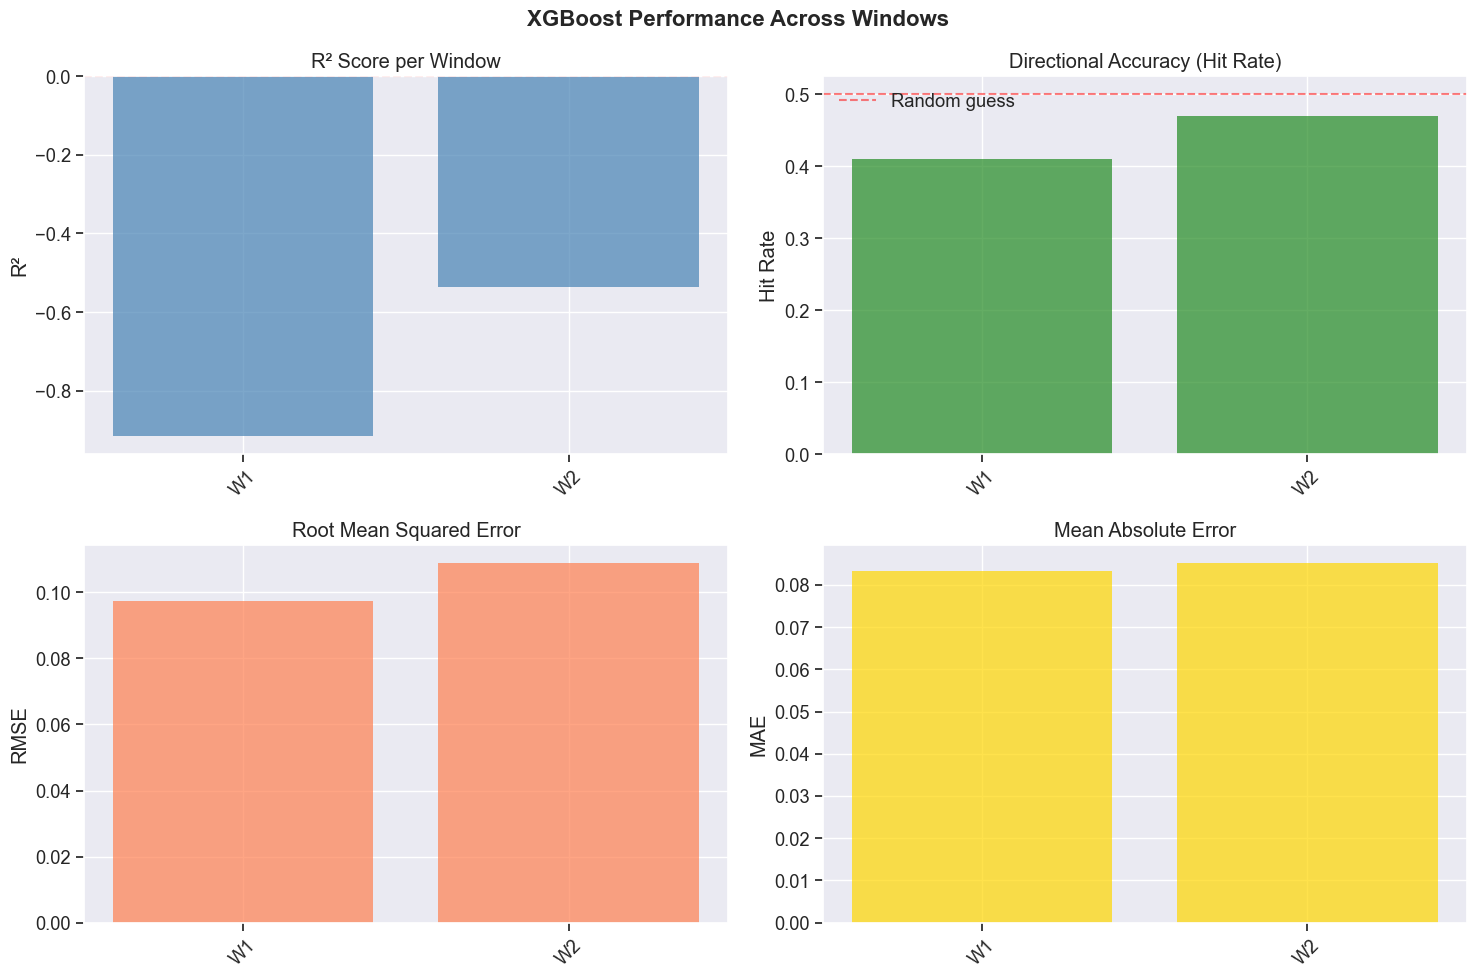

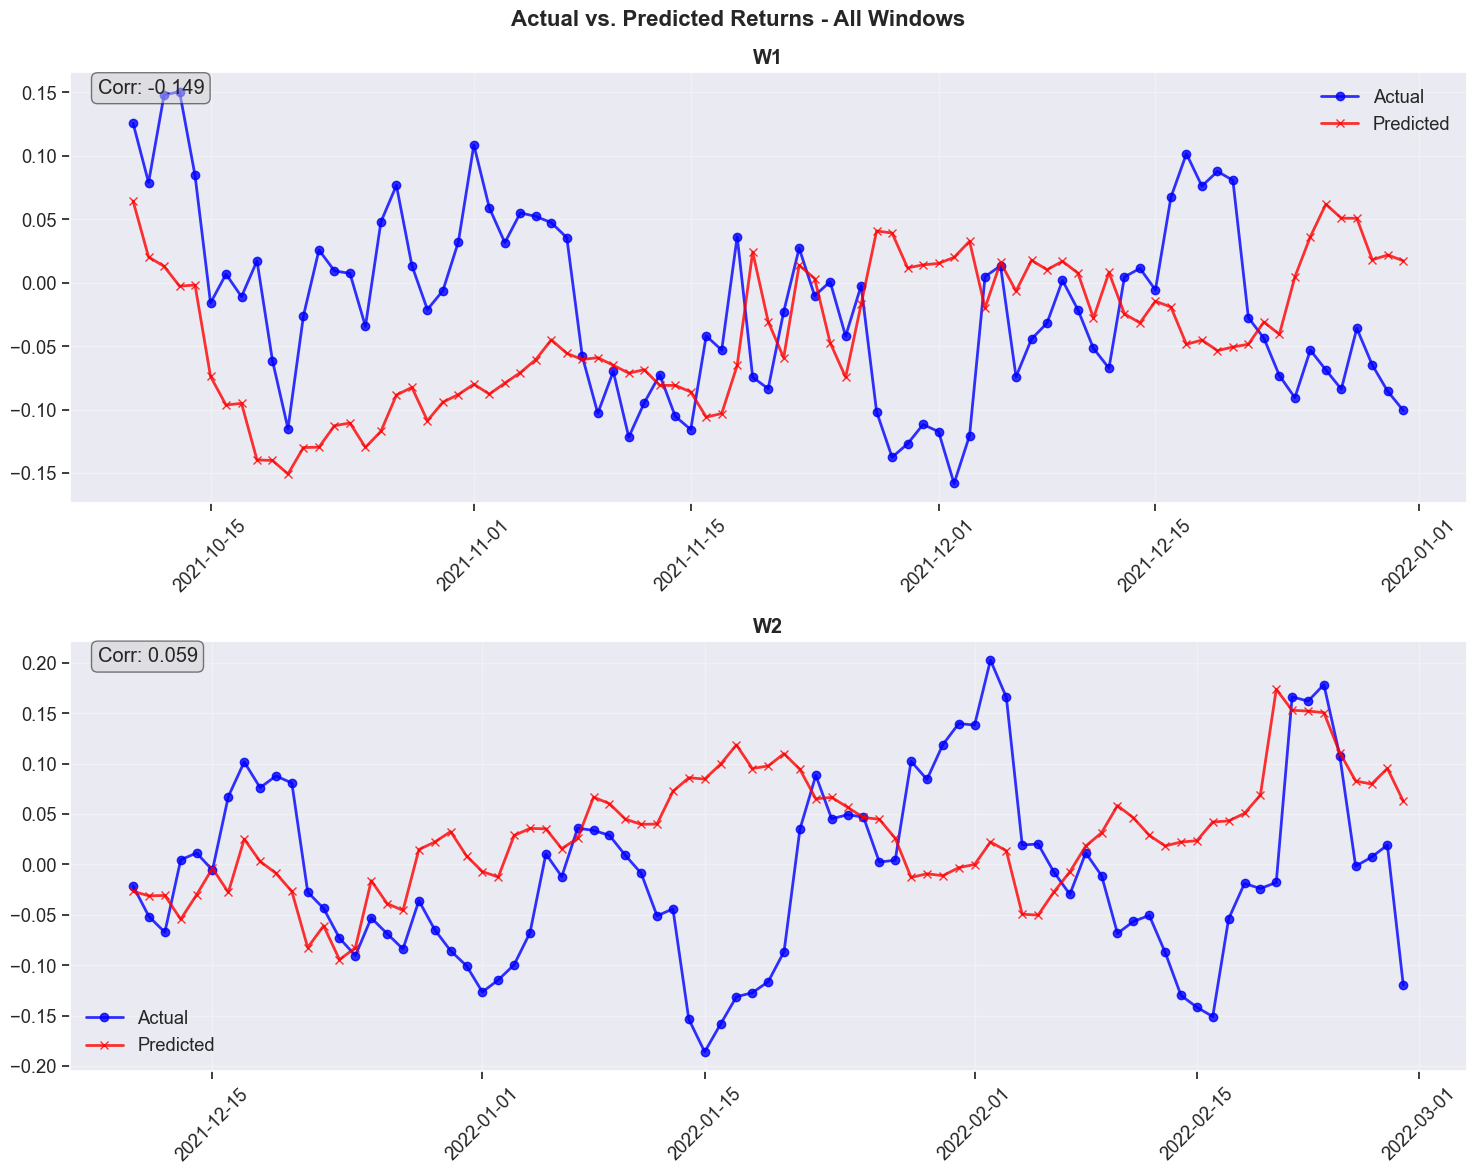

C:\Users\Kasper Hassing\AppData\Local\Temp\ipykernel_2008\3398501881.py:137: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  shap_matrix = shap_matrix.fillna(0)


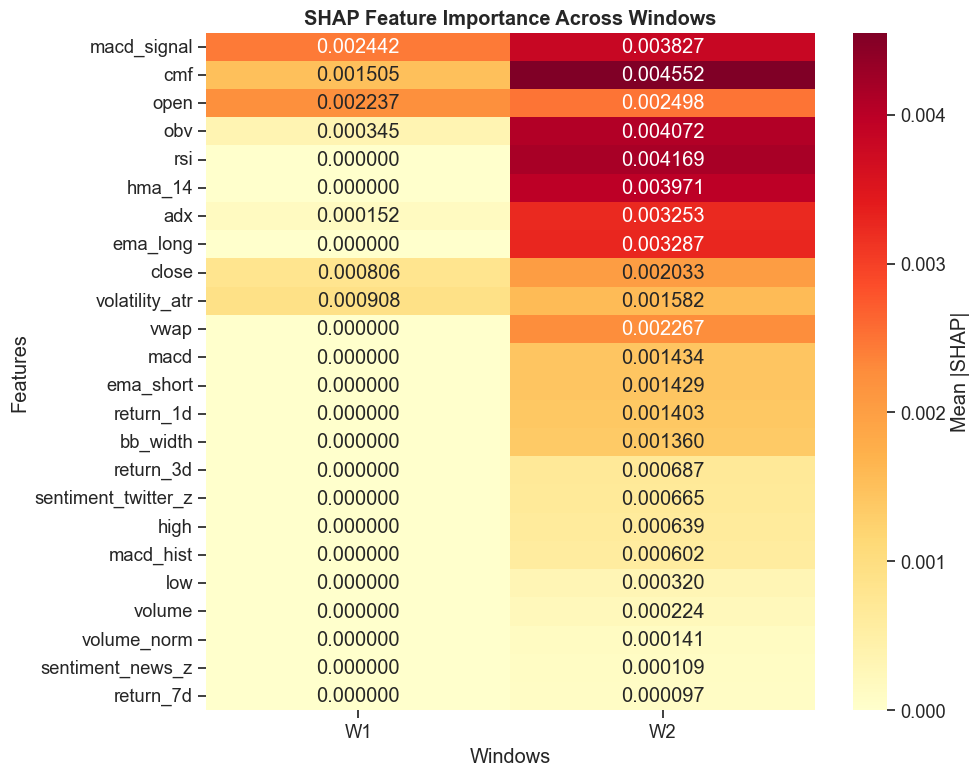

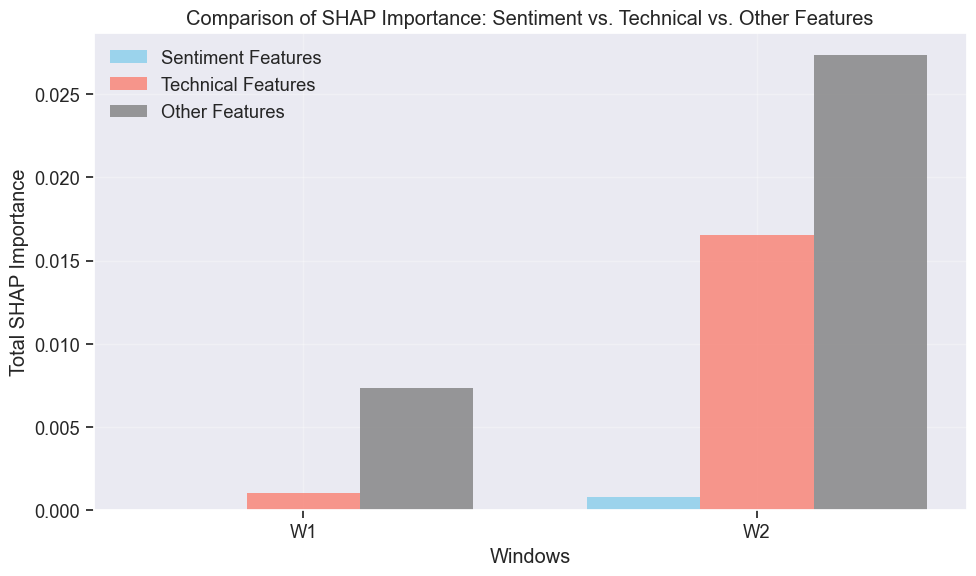

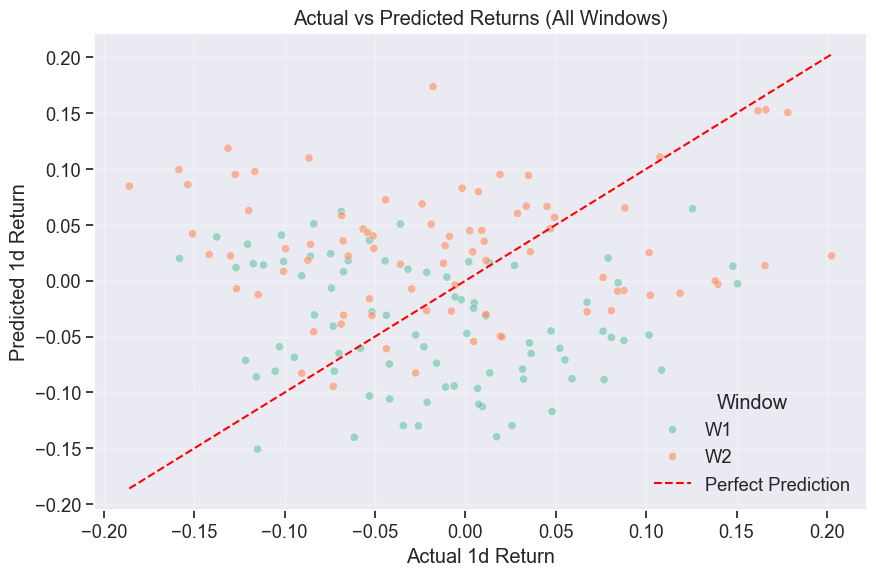


🧭 SHAP Survivor Analysis:


C:\Users\Kasper Hassing\AppData\Local\Temp\ipykernel_2008\3398501881.py:433: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  shap_matrix = shap_matrix.fillna(0)


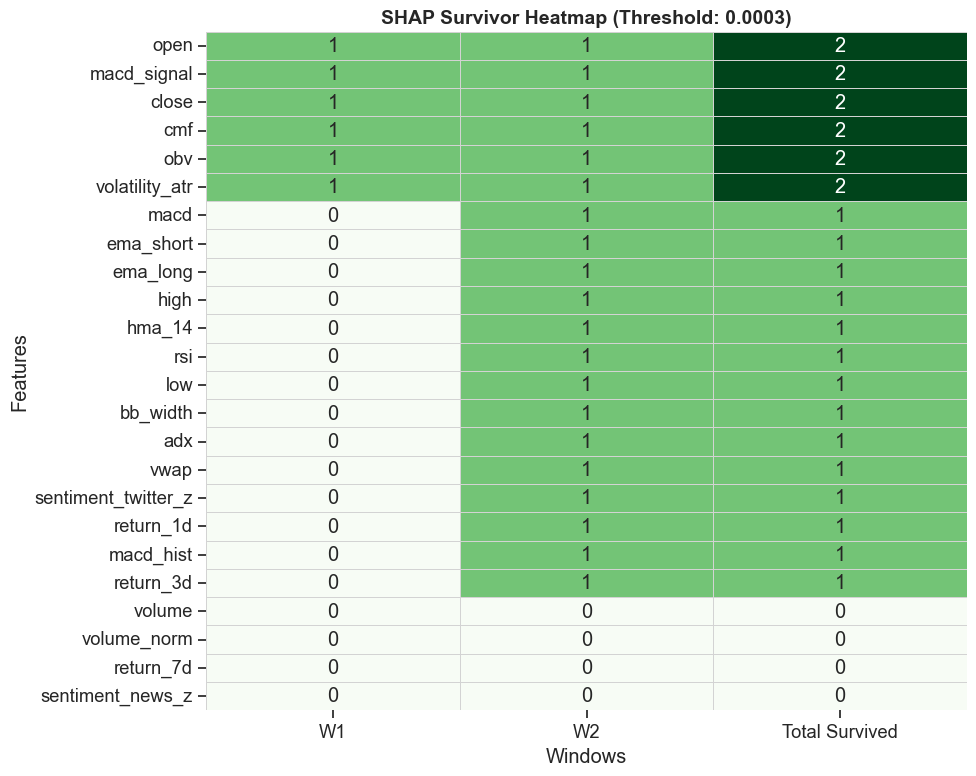

            feature  survival_count  avg_shap
        macd_signal               2  0.003135
                cmf               2  0.003028
               open               2  0.002368
                obv               2  0.002209
              close               2  0.001419
     volatility_atr               2  0.001245
                rsi               1  0.002084
             hma_14               1  0.001985
                adx               1  0.001703
           ema_long               1  0.001643
               vwap               1  0.001133
               macd               1  0.000717
          ema_short               1  0.000715
          return_1d               1  0.000701
           bb_width               1  0.000680
          return_3d               1  0.000343
sentiment_twitter_z               1  0.000333
               high               1  0.000320
          macd_hist               1  0.000301
                low               1  0.000160

✅ Færdig! Find alle dine plots og

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm
import shap
import os
import matplotlib.pyplot as plt
import seaborn as sns

# === STYLE SETTINGS ===
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("colorblind")
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = (12, 8)

# === SETTINGS ===
DATA_PATH = r"C:\Users\Kasper Hassing\Desktop\Speciale_KryptoSentiment\data\combined\BTCUSDT_features_final_sentiment.csv"
TARGET = "future_return_7d"
PURGE_DAYS = 5
OUTPUT_DIR = r"C:\Users\Kasper Hassing\Desktop\Speciale_KryptoSentiment\scripts\analysis\4.3\XGBoost"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === WINDOWS (SAME AS LSTM) ===
window_definitions = [
    {
        "name": "W1", 
        "train_start": "2021-01-01",
        "train_end": "2021-09-30", 
        "test_start": "2021-10-10", 
        "test_end": "2021-12-31"
    },
    {
        "name": "W2", 
        "train_start": "2021-01-01",
        "train_end": "2021-11-30", 
        "test_start": "2021-12-10", 
        "test_end": "2022-02-28"
    }
]

# === METRICS (SAME AS LSTM) ===
def evaluate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    corr, _ = pearsonr(y_true, y_pred)
    hit_rate = np.mean(np.sign(y_true) == np.sign(y_pred))
    return {"r2": r2, "mae": mae, "rmse": rmse, "corr": corr, "hit_rate": hit_rate}

# === PLOTTING FUNCTIONS ===
def plot_performance_across_windows(results_df):
    """Performance metrics across different windows"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('XGBoost Performance Across Windows', fontsize=16, fontweight='bold')
    
    # R² plot
    axes[0,0].bar(results_df['window'], results_df['r2'], color='steelblue', alpha=0.7)
    axes[0,0].set_title('R² Score per Window')
    axes[0,0].set_ylabel('R²')
    axes[0,0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Hit Rate plot
    axes[0,1].bar(results_df['window'], results_df['hit_rate'], color='forestgreen', alpha=0.7)
    axes[0,1].set_title('Directional Accuracy (Hit Rate)')
    axes[0,1].set_ylabel('Hit Rate')
    axes[0,1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random guess')
    axes[0,1].legend()
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # RMSE plot
    axes[1,0].bar(results_df['window'], results_df['rmse'], color='coral', alpha=0.7)
    axes[1,0].set_title('Root Mean Squared Error')
    axes[1,0].set_ylabel('RMSE')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # MAE plot
    axes[1,1].bar(results_df['window'], results_df['mae'], color='gold', alpha=0.7)
    axes[1,1].set_title('Mean Absolute Error')
    axes[1,1].set_ylabel('MAE')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'performance_across_windows.png'), dpi=300, bbox_inches='tight')
    plt.show()

def plot_predictions_comparison(pred_df_all):
    """Comparison of actual vs predicted values for all windows"""
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    fig.suptitle('Actual vs. Predicted Returns - All Windows', fontsize=16, fontweight='bold')
    
    windows = ['W1', 'W2']
    
    for i, win in enumerate(windows):
        subset = pred_df_all[pred_df_all["window"] == win]
        
        axes[i].plot(subset["date"], subset["actual"], 'o-', label="Actual", 
                    color='blue', alpha=0.8, linewidth=2)
        axes[i].plot(subset["date"], subset["predicted"], 'x-', label="Predicted", 
                    color='red', alpha=0.8, linewidth=2)
        
        axes[i].set_title(f'{win}', fontweight='bold')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        axes[i].tick_params(axis='x', rotation=45)
        
        # Add correlation as text
        corr = np.corrcoef(subset["actual"], subset["predicted"])[0,1]
        axes[i].text(0.02, 0.95, f'Corr: {corr:.3f}', transform=axes[i].transAxes, 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'predictions_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

def plot_shap_comparison_across_windows(all_shap_results):
    """Compare SHAP feature importance across windows"""
    
    # Create heatmap of top features
    all_features = set()
    for win_features in all_shap_results.values():
        all_features.update(win_features['feature'].head(15))
    
    shap_matrix = pd.DataFrame(index=list(all_features), 
                              columns=['W1', 'W2'])
    
    for win, features_df in all_shap_results.items():
        for _, row in features_df.iterrows():
            shap_matrix.loc[row['feature'], win] = row['mean_abs_shap']
    
    shap_matrix = shap_matrix.fillna(0)
    order = shap_matrix.sum(axis=1).sort_values(ascending=False).index
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(shap_matrix.loc[order], annot=True, fmt='.6f', cmap='YlOrRd', cbar_kws={'label': 'Mean |SHAP|'})
    plt.title('SHAP Feature Importance Across Windows', fontweight='bold')
    plt.xlabel('Windows')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'shap_heatmap.png'), dpi=300, bbox_inches='tight')
    plt.show()

def plot_sentiment_vs_technical_importance(all_shap_results):
    """Compare sentiment vs technical indicators"""
    
    sentiment_features = ['sentiment_twitter_z', 'sentiment_news_z']
    technical_features = ['rsi', 'macd', 'bb_width', 'volatility_atr', 'adx', 'ema_short', 'ema_long']
    
    sentiment_importance = []
    technical_importance = []
    other_importance = []
    windows = []
    
    for win, features_df in all_shap_results.items():
        windows.append(win)
        
        # Sum of sentiment importance
        sent_sum = features_df[features_df['feature'].isin(sentiment_features)]['mean_abs_shap'].sum()
        sentiment_importance.append(sent_sum)
        
        # Sum of technical importance
        tech_sum = features_df[features_df['feature'].isin(technical_features)]['mean_abs_shap'].sum()
        technical_importance.append(tech_sum)
        
        # Sum of other features
        all_feats = set(features_df['feature'])
        other_feats = all_feats - set(sentiment_features) - set(technical_features)
        other_sum = features_df[features_df['feature'].isin(other_feats)]['mean_abs_shap'].sum()
        other_importance.append(other_sum)
    
    # Bar plot
    x = np.arange(len(windows))
    width = 0.25
    
    plt.figure(figsize=(10, 6))
    plt.bar(x - width, sentiment_importance, width, label='Sentiment Features', 
            color='skyblue', alpha=0.8)
    plt.bar(x, technical_importance, width, label='Technical Features', 
            color='salmon', alpha=0.8)
    plt.bar(x + width, other_importance, width, label='Other Features', 
            color='gray', alpha=0.8)
    
    plt.xlabel('Windows')
    plt.ylabel('Total SHAP Importance')
    plt.title('Comparison of SHAP Importance: Sentiment vs. Technical vs. Other Features')
    plt.xticks(x, windows)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'sentiment_vs_technical.png'), dpi=300, bbox_inches='tight')
    plt.show()

# === LOAD DATA ===
df = pd.read_csv(DATA_PATH, parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)
assert df.index.is_unique, "❌ Duplicate timestamps found"

# === PREPARATION FUNCTION (SIMPLIFIED - NO FEATURE LOOKBACKS) ===
def prepare_data(df, train_start, train_end, test_start, test_end, active_features=None):
    df = df.copy()
    train_start = pd.to_datetime(train_start)
    train_end = pd.to_datetime(train_end)
    test_start = pd.to_datetime(test_start)
    test_end = pd.to_datetime(test_end)

    # Create purge period
    purge_start = test_start - timedelta(days=PURGE_DAYS)
    
    train_df = df[(df.index >= train_start) & (df.index <= purge_start)]
    test_df = df[(df.index >= test_start) & (df.index <= test_end)].copy()

    # === Feature set logic ===
    feature_cols = [col for col in df.columns if not col.startswith("future_return")]
    if active_features is not None:
        feature_cols = [f for f in feature_cols if f in active_features]

    # === Drop features with too many NaNs ===
    nan_threshold = 0.95
    nan_ratios = test_df[feature_cols].isna().mean()
    features_to_drop = nan_ratios[nan_ratios > nan_threshold].index.tolist()
    if features_to_drop:
        print(f"⚠️ Dropping features from test_df due to excessive NaNs: {features_to_drop}")
        feature_cols = [f for f in feature_cols if f not in features_to_drop]

    # Remove duplicates
    feature_cols = list(dict.fromkeys(feature_cols))

    train_df = train_df.dropna(subset=feature_cols + [TARGET])
    test_df = test_df.dropna(subset=feature_cols + [TARGET])

    X_train, y_train = train_df[feature_cols], train_df[TARGET]
    X_test, y_test = test_df[feature_cols], test_df[TARGET]

    return X_train, y_train, X_test, y_test, feature_cols, test_df.index

# === MAIN LOOP ===
SHAP_THRESHOLD = 0.0003
MIN_FEATURES = 8

results = []
all_preds = []
all_shap_results = {}

for win in tqdm(window_definitions, desc="Walk-Forward Windows"):
    print(f"\n🔍 {win['name']} – Training: {win['train_start']} → {win['train_end']} | Test: {win['test_start']} → {win['test_end']}")

    # First training with ALL features
    X_train, y_train, X_test, y_test, feature_cols, test_dates = prepare_data(
        df, win["train_start"], win["train_end"], win["test_start"], win["test_end"]
    )

    if X_test.empty or y_test.empty:
        print(f"⚠️ {win['name']}: Test data is empty! Skipping this window.")
        continue

    # Split training data for validation
    val_size = int(len(X_train) * 0.2)
    X_val = X_train.iloc[-val_size:]
    y_val = y_train.iloc[-val_size:]
    X_train = X_train.iloc[:-val_size]
    y_train = y_train.iloc[:-val_size]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)

    params = {
        "objective": "reg:squarederror",
        "learning_rate": 0.07,
        "max_depth": 4,
        "min_child_weight": 1,
        "subsample": 0.5,
        "colsample_bytree": 0.6,
        "reg_alpha": 0.05,
        "reg_lambda": 0.5,
        "gamma": 0.0,
        "eval_metric": "rmse",
        "seed": 42
    }

    evals = [(dtrain, 'train'), (dval, 'validation')]
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=100000,
        evals=evals,
        early_stopping_rounds=100,
        verbose_eval=False
    )

    # Step 1: SHAP Explanation
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)

    top_features = pd.DataFrame({
        "feature": feature_cols,
        "mean_abs_shap": np.abs(shap_values.values).mean(axis=0)
    }).sort_values(by="mean_abs_shap", ascending=False)

    # Save SHAP results
    all_shap_results[win['name']] = top_features

    print(f"\n🔍 Top SHAP features for {win['name']}:")
    print(top_features.head(10).to_string(index=False))

    # Step 2: Prune features under threshold
    filtered_features = top_features[top_features["mean_abs_shap"] >= SHAP_THRESHOLD]["feature"].tolist()
    print(f"✂️ {win['name']}: Dropping {len(feature_cols) - len(filtered_features)} features under SHAP threshold ({SHAP_THRESHOLD})")

    # Ensure minimum number of features survive
    if len(filtered_features) < MIN_FEATURES:
        print(f"⚠️ Only {len(filtered_features)} features passed threshold, using top-{MIN_FEATURES} features instead")
        filtered_features = top_features["feature"].head(MIN_FEATURES).tolist()
    print(f" Using {len(filtered_features)} features that passed SHAP threshold")

    # Step 3: Retrain with pruned features
    X_train, y_train, X_test, y_test, final_features, test_dates = prepare_data(
        df, win["train_start"], win["train_end"], win["test_start"], win["test_end"], active_features=filtered_features
    )
    
    print(f" {win['name']}: Final features used for retrain: {final_features}")

    # Split training data for validation again
    val_size = int(len(X_train) * 0.2)
    X_val = X_train.iloc[-val_size:]
    y_val = y_train.iloc[-val_size:]
    X_train = X_train.iloc[:-val_size]
    y_train = y_train.iloc[:-val_size]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=100000,
        evals=[(dtrain, 'train'), (dval, 'validation')],
        early_stopping_rounds=100,
        verbose_eval=False
    )

    # Predict & metrics
    y_pred = model.predict(dtest)
    metrics = evaluate_metrics(y_test, y_pred)
    
    # Add Information Coefficient (Spearman correlation)
    metrics["ic"], _ = spearmanr(y_test, y_pred)

    print(f" {win['name']}: R²={metrics['r2']:.4f} | MAE={metrics['mae']:.4f} | RMSE={metrics['rmse']:.4f} | Hit={metrics['hit_rate']:.4f} | IC={metrics['ic']:.4f}")

    results.append({
        "window": win['name'],
        **metrics,
        "best_iteration": model.best_iteration
    })

    all_preds.append(pd.DataFrame({
        "date": test_dates,
        "actual": y_test.values,
        "predicted": y_pred,
        "window": win['name']
    }))

# === SAVE RESULTS ===
results_df = pd.DataFrame(results)
pred_df_all = pd.concat(all_preds, ignore_index=True)

print("\n OVERALL RESULTS TABLE:")
print(results_df[["window", "r2", "corr", "mae", "rmse", "hit_rate", "ic"]].round(4))

# === SAVE DATA ===
results_df.to_csv(os.path.join(OUTPUT_DIR, 'results_summary.csv'), index=False)
pred_df_all.to_csv(os.path.join(OUTPUT_DIR, 'all_predictions.csv'), index=False)

# Save SHAP results
for win, shap_df in all_shap_results.items():
    shap_df.to_csv(os.path.join(OUTPUT_DIR, f'shap_features_{win}.csv'), index=False)

print(f"\n Results saved to: {OUTPUT_DIR}")

# === COMPREHENSIVE PLOTTING ===
print("\n Generating key plots...")

# 1. Performance overview
plot_performance_across_windows(results_df.copy())

# 2. Predictions comparison
plot_predictions_comparison(pred_df_all)

# 3. SHAP Feature Importance Heatmap
plot_shap_comparison_across_windows(all_shap_results)

# 4. Sentiment vs. Technical SHAP Comparison
plot_sentiment_vs_technical_importance(all_shap_results)

# 5. Combined scatter plot (like LSTM)
plt.figure(figsize=(9, 6))
sns.scatterplot(data=pred_df_all, x="actual", y="predicted", hue="window", alpha=0.6, palette="Set2")
min_val = min(pred_df_all["actual"].min(), pred_df_all["predicted"].min())
max_val = max(pred_df_all["actual"].max(), pred_df_all["predicted"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1.5, label="Perfect Prediction")
plt.xlabel("Actual 1d Return")
plt.ylabel("Predicted 1d Return")
plt.title("Actual vs Predicted Returns (All Windows)")
plt.grid(True, alpha=0.3)
plt.legend(title="Window")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'scatter_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# 6. SHAP Survivor Analysis
print("\n SHAP Survivor Analysis:")
SHAP_THRESHOLD = 0.0003

# Create binary survivor matrix
all_features = set()
for win_features in all_shap_results.values():
    all_features.update(win_features['feature'].head(15))

shap_matrix = pd.DataFrame(index=list(all_features), columns=['W1', 'W2'])

for win, features_df in all_shap_results.items():
    for _, row in features_df.iterrows():
        shap_matrix.loc[row['feature'], win] = row['mean_abs_shap']

shap_matrix = shap_matrix.fillna(0)
binary_survivor_matrix = shap_matrix.copy()
binary_survivor_matrix[binary_survivor_matrix >= SHAP_THRESHOLD] = 1
binary_survivor_matrix[binary_survivor_matrix < SHAP_THRESHOLD] = 0
binary_survivor_matrix["Total Survived"] = binary_survivor_matrix.sum(axis=1)
binary_survivor_matrix = binary_survivor_matrix.sort_values(by="Total Survived", ascending=False)

plt.figure(figsize=(10, 8))
sns.heatmap(binary_survivor_matrix, annot=True, cmap="Greens", cbar=False, linewidths=0.5, linecolor="lightgray", fmt='.0f')
plt.title(f'SHAP Survivor Heatmap (Threshold: {SHAP_THRESHOLD})', fontsize=14, fontweight='bold')
plt.xlabel('Windows')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'shap_survivor_heatmap_binary.png'), dpi=300, bbox_inches='tight')
plt.show()

# Feature survival summary
shap_survivor_counts = {}
for win, shap_df in all_shap_results.items():
    survivors = shap_df[shap_df["mean_abs_shap"] >= SHAP_THRESHOLD]["feature"]
    for feat in survivors:
        shap_survivor_counts[feat] = shap_survivor_counts.get(feat, 0) + 1

shap_summary_df = pd.DataFrame()
for win, shap_df in all_shap_results.items():
    shap_df = shap_df.copy()
    shap_df["window"] = win
    shap_summary_df = pd.concat([shap_summary_df, shap_df], ignore_index=True)

shap_avg = shap_summary_df.groupby("feature")["mean_abs_shap"].mean().sort_values(ascending=False).reset_index()
shap_avg.columns = ["feature", "avg_shap"]

shap_survivor_df = pd.DataFrame([{"feature": f, "survival_count": count} for f, count in shap_survivor_counts.items()])
shap_survivor_df = shap_survivor_df.merge(shap_avg, on="feature", how="left")
shap_survivor_df = shap_survivor_df.sort_values(by=["survival_count", "avg_shap"], ascending=False)

print(shap_survivor_df.head(20).to_string(index=False))

print("\n✅ Færdig! Find alle dine plots og resultater i:", OUTPUT_DIR)